In [1]:
# Articles Consulted
# https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import datetime as dt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [160]:
data = pd.read_csv("../data/state-daily-stats.csv")
data.drop(columns={"Unnamed: 0"}, inplace=True)

In [161]:
# for index, row in data.iterrows():
#     date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
#     date2 = dt.datetime.strftime(date, "%m-%d-%Y")
#     data.at[index, "date"] = date2

In [172]:
data["date"] = pd.to_datetime(data["date"])
daily_new_cases = pd.DataFrame(data[["date","daily_new_cases"]])

In [173]:
daily_new_cases.reset_index(drop=True)

,date,daily_new_cases
0,2020-01-21,1
1,2020-01-22,0
2,2020-01-23,0
3,2020-01-24,1
4,2020-01-25,1
...,...,...
410,2021-03-06,56606
411,2021-03-07,40336
412,2021-03-08,98513
413,2021-03-09,55832


In [174]:
daily_new_cases = daily_new_cases[daily_new_cases["date"] >= dt.datetime(2020,3,1)] 

### Update dates to proper datetime for modeling

In [175]:
# daily_new_cases = daily_new_cases[daily_new_cases["date"] >= dt.datetime(2020,3,1)]
for index, row in daily_new_cases.iterrows():
    date = row["date"]
    new_date = dt.datetime.strftime(date, "%m-%d-%Y")
    daily_new_cases.at[index, "date"] = new_date

In [176]:
# daily_new_cases[daily_new_cases["daily_new_cases"] == 0]

In [177]:
daily_new_cases.set_index("date", inplace=True)

### Check Autocorrelation (ACF, PACF)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

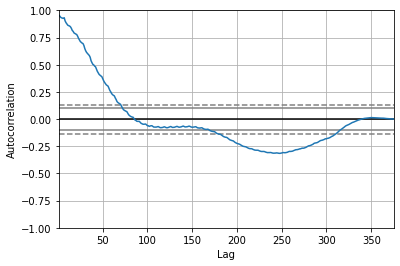

In [178]:
autocorrelation_plot(daily_new_cases)

**Data Transformation**
- By the above, we see some seasonal spikes
- We also see that the time series is not stationary

In [179]:
# Taking the log for this data provides better results than .diff() 
test_df = np.log(daily_new_cases)

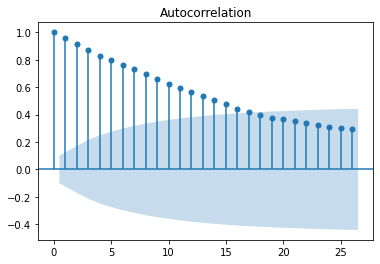

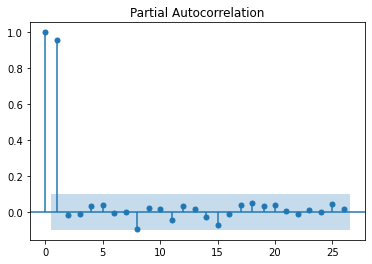

In [180]:
# Replot ACF / PACF to check data
ACF = plot_acf(test_df)
PACF = plot_pacf(test_df)

**The PACF above looks good, less so for the ACF.**
- Let's check the Dickey-Fuller Score and P-Value
- A P-Value > .05 means our data still isn't stationary

In [181]:
result = adfuller(test_df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.3425762487830144
p-value: 0.013079323038096355


- The P-Value is ok, and the data appears to be stationary for the most part. 
- We'll move forward with splitting our data into training/testing

**Training / Testing**
- This pretty much splits the data into 75/25

In [182]:
training = test_df[:275]
testing = test_df[275:]

## Auto ARIMA Testing

- Use Auto ARIMA to look for the best p, d, q
- Use Auto ARIMA for SARIMA model to find best p, d, q, & P, D, Q 

*note: Template code provided here: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/*. 

In [183]:
# Import pmdarima
import pmdarima as pm

In [184]:
amodel = pm.auto_arima(training, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=7,             
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(amodel.summary())

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-148.132, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2071.301, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1704.001, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-144.805, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-148.250, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1359.631, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-145.536, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-149.239, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1103.067, Time=0.25 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-148.793, Time=0.44 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 2.704 seconds
                               SARIMAX Results                                
Dep. Variable:     

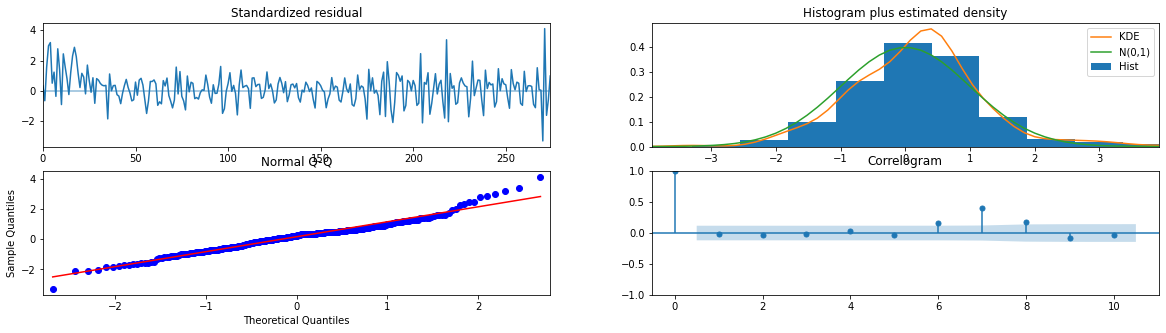

In [185]:
amodel.plot_diagnostics(figsize=(20,5))
plt.show()

In [186]:
n_periods = 124
arima_predictions = amodel.predict(n_periods=n_periods)

In [187]:
arima = []
for x in arima_predictions:
    p = np.expm1(x)
    arima.append(round(p))

In [188]:
arima_df = pd.DataFrame(arima)
arima_df.rename(columns={0: "arima_model"}, inplace=True)

In [189]:
arima_df

,arima_model
0,162338
1,163206
2,165499
3,164844
4,164192
...,...
119,104996
120,104596
121,104198
122,103802


In [190]:
arima_analysis = testing.reset_index()

for index, row in arima_analysis.iterrows():
    x = row[1]
    arima_analysis.at[index, "original_daily"] = np.expm1(x)

In [191]:
arima_analysis = pd.merge(arima_analysis, arima_df, left_index=True, right_index=True)
arima_analysis.set_index("date", inplace=True)
arima_analysis.drop(columns="daily_new_cases", inplace=True)

<AxesSubplot:xlabel='date'>

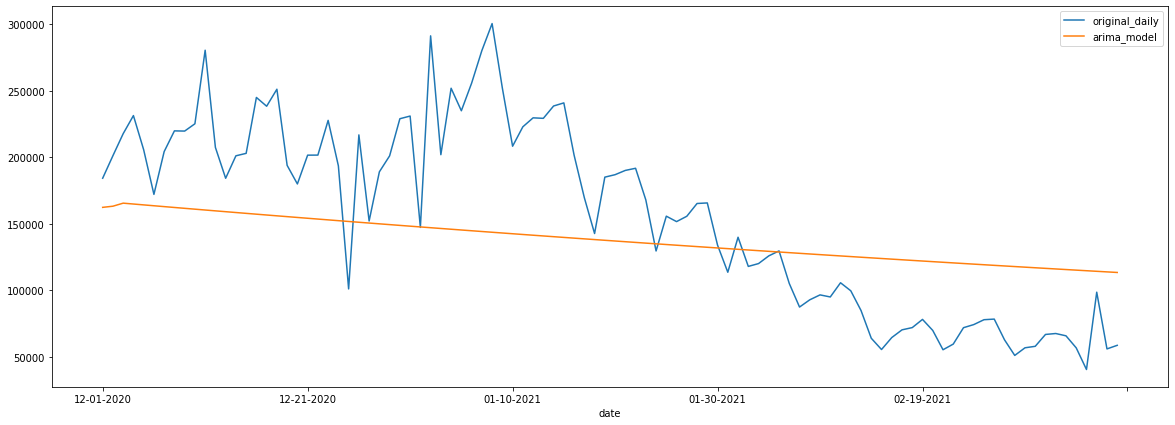

In [192]:
# Doesn't capture seasonality, only the trend
arima_analysis.plot(figsize=(20, 7))

### SARIMA Model Testing

In [193]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(training, start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=327.776, Time=0.18 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=447.982, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=181.734, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=484.136, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=223.500, Time=0.08 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=94.409, Time=0.35 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=106.715, Time=0.29 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=70.842, Time=0.79 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=78.194, Time=0.62 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=65.612, Time=1.09 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=64.070, Time=0.78 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=97.655, Time=0.49 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=173.144, Time=0.48 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=-279.491, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  275
Model:             SARIMAX(1, 0, 3)x(2, 1, [1], 7)   Log Likelihood                 154.609
Date:                             Fri, 12 Mar 2021   AIC                           -293.218
Time:                                     13:12:19   BIC                           -264.490
Sample:                                          0   HQIC                          -281.680
                                             - 275                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.002    572.523      0.000       0.995       1.002
ma.L1         -0.2618      0.040     -6.614      0.000      -0.339      -0.184
ma.L2          0.1116      0.064      1.748      0.080      -0.014       0.237
ma.L3          0.1725      0.058      2.976      0.003       0.059       0.286
ar.S.L7        0.1261      0.130      0.968      0.333      -0.129       0.381
ar.S.L14       0.3154      0.099      3.194      0.001       0.122       0.509
ma.S.L7       -0.8671      0.118     -7.325      0.000      -1.099      -0.635
sigma2         0.0179      0.001     19.975      0.000       0.016       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):               237.42
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.02
Prob(H) (two-sided):                  0.39   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

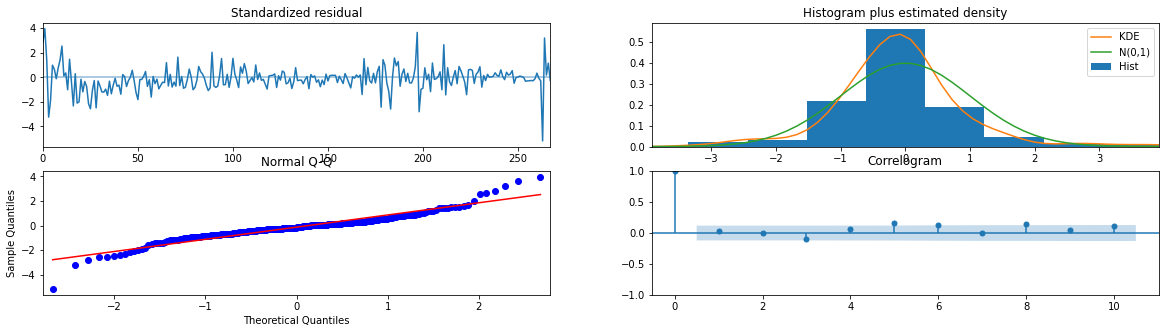

In [194]:
smodel.plot_diagnostics(figsize=(20,5))
plt.show()

In [195]:
n_periods = 123
predictions_seasonal = smodel.predict(n_periods=n_periods)

<AxesSubplot:>

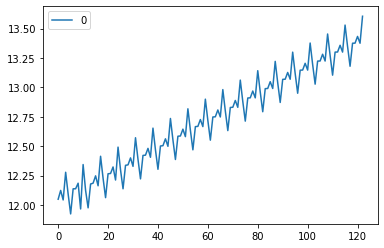

In [196]:
pd.DataFrame(predictions_seasonal).plot()

In [207]:
predictions_list = []

for x in predictions_seasonal:
    prediction = np.expm1(x)
    predictions_list.append(round(prediction))

In [208]:
sarima_model = pd.DataFrame(predictions_list)
sarima_model.rename(columns={0:"sarima_model"}, inplace=True)

In [209]:
sarima_model

,sarima_model
0,170828
1,184086
2,169795
3,214858
4,178507
...,...
118,643864
119,644402
120,682197
121,643792


In [210]:
arima_analysis.reset_index(inplace=True, drop=True)

In [213]:
model_analyses = pd.merge(arima_analysis, sarima_model, left_index=True, right_index=True)
model_analyses.drop(columns={"arima_model"}, inplace=True)

In [214]:
# model_analyses.drop(columns={"level_0", "index"}, inplace=True)

<AxesSubplot:>

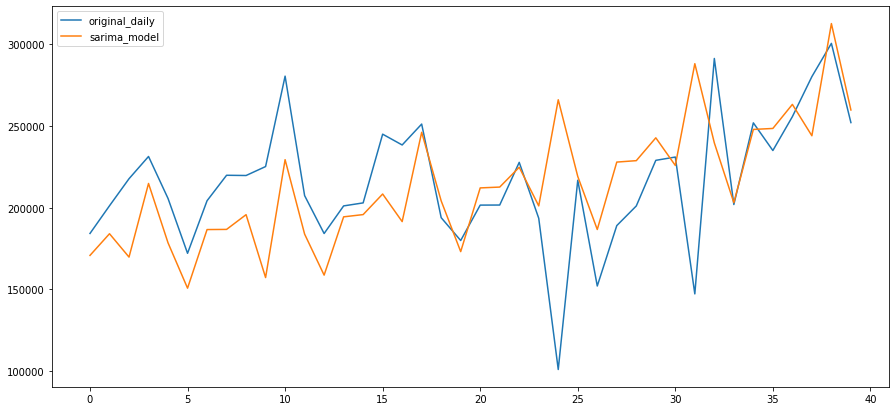

In [216]:
model_analyses[:40].plot(figsize=(15, 7))

# Finalized SARIMA Model Below

### Test on Training Data once more to make sure
- Now that we have the SARIMA (*p, d, q*) & (*P, D, Q), we can start setting up the offical Model
- First, we test again with the training data

In [34]:
# First, test 
training 

,daily_new_cases
date,
03-01-2020,2.890372
03-02-2020,2.772589
03-03-2020,3.044522
03-04-2020,3.583519
03-05-2020,4.204693
...,...
11-26-2020,11.541445
11-27-2020,12.235078
11-28-2020,11.926002


In [88]:
# Fit model SARIMAX(1, 0, 3)x(2, 0, [1], 7)
mod = sm.tsa.statespace.SARIMAX(training, trend='c', order=(1,0,3), seasonal_order=(2, 0, 1, 7))
res = mod.fit(disp=False)
print(res.summary())

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                      
Dep. Variable:                     daily_new_cases   No. Observations:                  275
Model:             SARIMAX(1, 0, 3)x(2, 0, [1], 7)   Log Likelihood                 152.858
Date:                             Fri, 12 Mar 2021   AIC                           -287.716
Time:                                     13:01:51   BIC                           -255.165
Sample:                                 03-01-2020   HQIC                          -274.652
                                      - 11-30-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.008      0.157      0.875      -0.015       0.017
ar.L1          0.9920      

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [81]:
SARIMA_predictions = res.predict(start="11-30-2020", end="03-09-2021")
SARIMA_new = pd.DataFrame(SARIMA_predictions)

In [82]:
SARIMA_new
for index, row in SARIMA_new.iterrows():
    sarima_p = round(np.expm1(row["predicted_mean"]))
    SARIMA_new.at[index, "sarima_model_new"] = sarima_p

<AxesSubplot:>

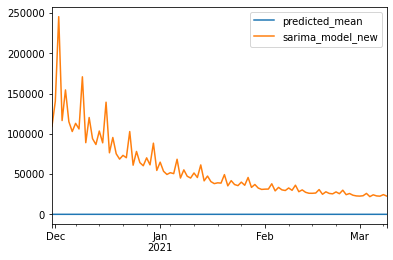

In [83]:
SARIMA_new.plot()

In [84]:
observed = daily_new_cases[-100:]

In [85]:
observed

,daily_new_cases
date,
12-01-2020,184260
12-02-2020,201211
12-03-2020,217763
12-04-2020,231387
12-05-2020,205673
...,...
03-06-2021,56606
03-07-2021,40336
03-08-2021,98513


In [86]:
SARIMA_new.drop(columns={"predicted_mean"}, inplace=True)

<AxesSubplot:>

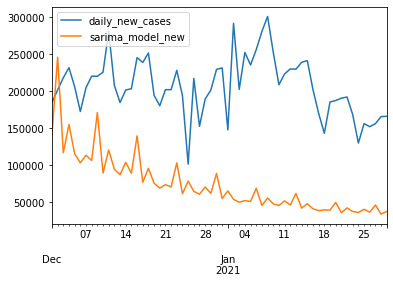

In [87]:
first_30 = pd.merge(observed, SARIMA_new, left_index=True, right_index=True )
first_30[:60].plot()

- It captures the trend and seasonality

## Make Final Model Using the Full Dataset

In [157]:
# Take the log of the data to make it stationary
log_daily_new_cases = np.log(daily_new_cases)

In [158]:
log_daily_new_cases

,daily_new_cases
date,
03-01-2020,2.890372
03-02-2020,2.772589
03-03-2020,3.044522
03-04-2020,3.583519
03-05-2020,4.204693
...,...
03-06-2021,10.943870
03-07-2021,10.605000
03-08-2021,11.497944


In [159]:
# Create final model with perameters
final_mod = sm.tsa.statespace.SARIMAX(log_daily_new_cases, trend='c', order=(1,0,3), seasonal_order=(2, 0, 1, 7))
final_res = final_mod.fit(disp=False)
print(res.summary())

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                      
Dep. Variable:                     daily_new_cases   No. Observations:                  275
Model:             SARIMAX(1, 0, 3)x(2, 0, [1], 7)   Log Likelihood                 152.858
Date:                             Thu, 11 Mar 2021   AIC                           -287.716
Time:                                     22:49:04   BIC                           -255.165
Sample:                                 03-01-2020   HQIC                          -274.652
                                      - 11-30-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.008      0.157      0.875      -0.015       0.017
ar.L1          0.9920      

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [160]:
# Make Predictions for all of March to first day of April
predictions = final_res.forecast(steps=30)

# Create Data Frame and convert from log
predictions_df = pd.DataFrame(np.expm1(predictions))

In [161]:
predictions_df.reset_index().rename(columns={"index": "date"}, inplace=True)

In [162]:
predictions_df.reset_index(inplace=True)
predictions_df.rename(columns={"index": "date"}, inplace=True)
predictions_df.set_index("date", inplace=True)

In [163]:
observed = daily_new_cases.reset_index()

In [164]:
observed["date"] = pd.to_datetime(observed["date"])
march_observed = observed[observed["date"] >= "03-01-2021"]

<AxesSubplot:xlabel='date'>

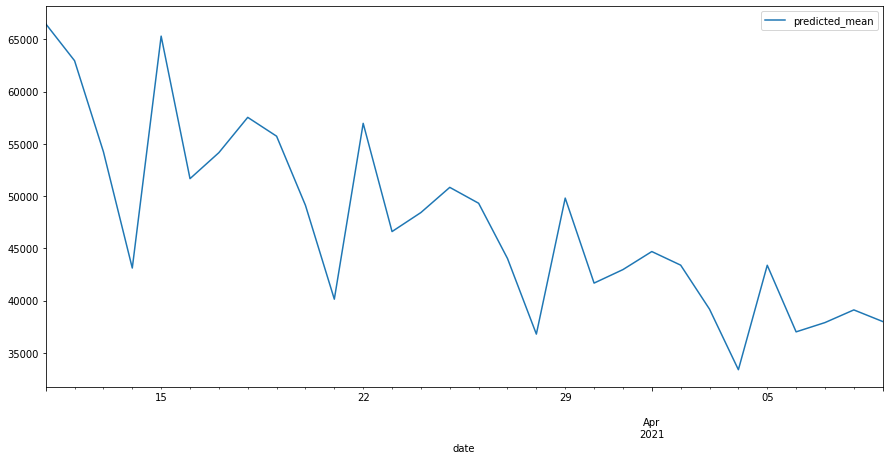

In [165]:
predictions_df.plot(figsize=(15, 7))

In [166]:
predictions_df

,predicted_mean
date,
2021-03-11,66503.486927
2021-03-12,62969.626772
2021-03-13,54252.638534
2021-03-14,43126.168832
2021-03-15,65320.580135
2021-03-16,51680.145408
2021-03-17,54169.471973
2021-03-18,57547.551375
2021-03-19,55743.817122


In [167]:
predictions_df.to_csv(f"../data/30_day_predictions.csv", index_label="date")

In [168]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2021-03-11 to 2021-04-09
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   predicted_mean  30 non-null     float64
dtypes: float64(1)
memory usage: 480.0 bytes


In [169]:
predictions_df.reset_index(inplace=True)
predictions_df.rename(columns={"index": "date"}, inplace=True)

In [75]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            30 non-null     datetime64[ns]
 1   predicted_mean  30 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 608.0 bytes


# Upload 30-Day Predictions to AWS RDS

In [76]:
# Config Variables, and SQLalchemy
from config import endpoint, username, password
from sqlalchemy import create_engine

engine = create_engine(f'postgresql://uscovid:{password}@{endpoint}/us_covid_db')
connection = engine.connect()

In [77]:
predictions_df.to_sql('thirty_day_prediction', index=True, if_exists='replace', con=connection)
engine.execute('ALTER TABLE thirty_day_prediction ADD PRIMARY KEY (index);')